In [1]:
from common_utils import (
    fix_randomness,
    generate_experiment1a_blobs,
    generate_experiment1b_blobs,
    plot_blob_data,
    plot_without_noise,
    z_scale_np_array
)
from sklearn.cluster import HDBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from time import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 42
fix_randomness(seed)

# Experiment 1A: Hand picked samples

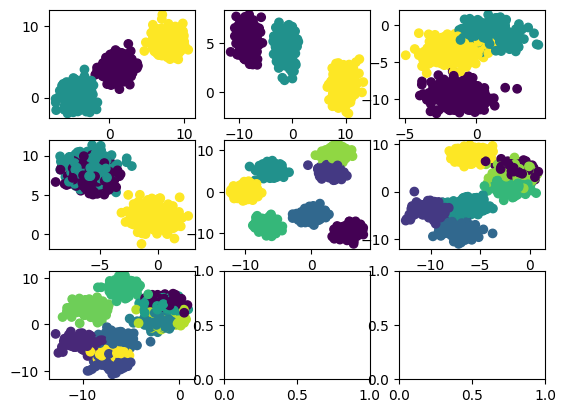

In [2]:
# Blobs for Experiment 1a
# First 3 blobs have 3 clusters
# Last 3 blobs have 7 clusters
blobs_1a = generate_experiment1a_blobs()
plot_blob_data(blobs_1a)

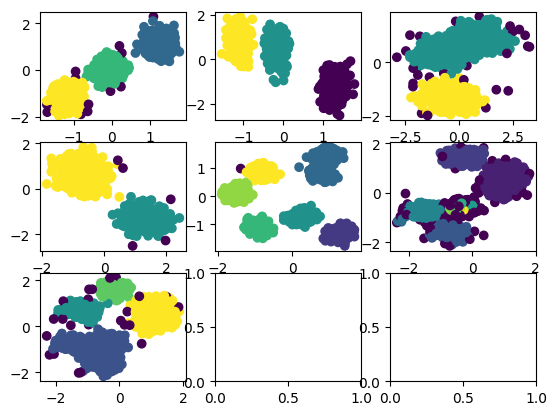

In [3]:
# HDBScan applied. Notice that cluster size is not a parameter
# Therefore, it can determine the number of clusters by itself.
# Moreover, it can also detect noise points -- its a modification
# of DBSCAN/OPTICS

# Label has been replaced with predictions
blobs_1a_with_predictions = list()

for blob in blobs_1a:
    hdb = HDBSCAN()
    blobs_1a_with_predictions.append(
        (
            z_scale_np_array(blob[0]),
            hdb.fit_predict(blob[0])
        )
    )

plot_blob_data(blobs_1a_with_predictions)

# Experiment 1B: Evaluating average performance

In [4]:
sample_sizes = [128, 256, 512, 1024, 2048, 4096]
cluster_counts = [4, 8, 16, 32, 64, 128]
n = 100

ss_blob_dict, cc_blob_dict = generate_experiment1b_blobs(
    seed,
    sample_sizes,
    cluster_counts,
    n
)

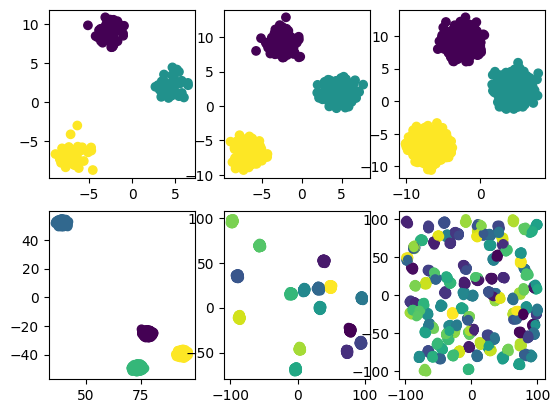

In [5]:
# Lets' take a plot of the representatives so that we have an idea of what's being generated
representative_blob_list = [
    ss_blob_dict[128][0], ss_blob_dict[512][0], ss_blob_dict[4096][0],
    cc_blob_dict[4][0], cc_blob_dict[16][0], cc_blob_dict[128][0],
]
plot_blob_data(representative_blob_list)

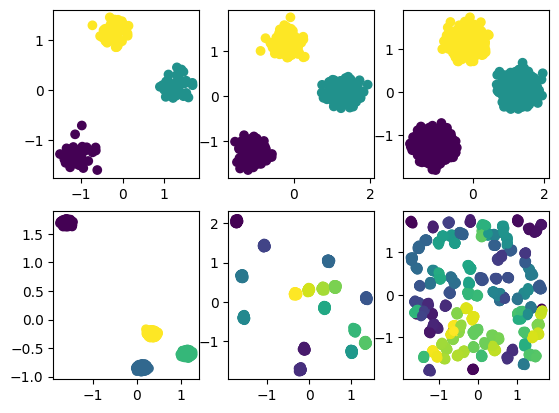

In [6]:
# See how these representatives are clustered
respresentative_with_predictions = list()

for blob in representative_blob_list:
    hdb = HDBSCAN()
    respresentative_with_predictions.append(
        (
            z_scale_np_array(blob[0]),
            hdb.fit_predict(blob[0])
        )
    )

plot_blob_data(respresentative_with_predictions)

0.7855238304174624
0.7135823895859742


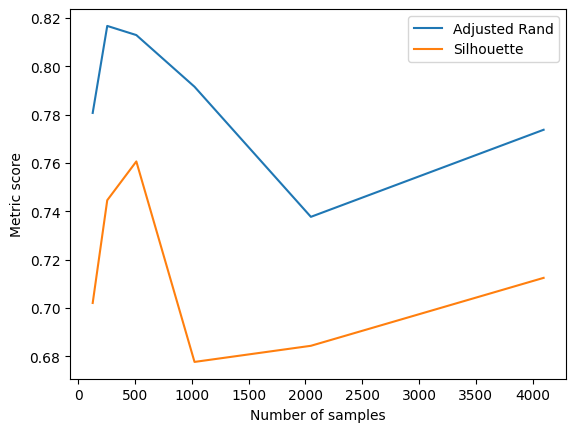

In [8]:
ss_ar_scores = list()
ss_sil_scores = list()
ss_average_times = list()
for ss in sample_sizes:
    sum_adjusted_rand = 0
    sum_sil = 0
    total_time = 0
    for blob in ss_blob_dict[ss]:
        start_time = time()
        hdb = HDBSCAN()
        pred = hdb.fit_predict(z_scale_np_array(blob[0]))
        sum_adjusted_rand += adjusted_rand_score(blob[1], pred)
        sum_sil += silhouette_score(blob[0], pred)
        total_time += time() - start_time
    average_adjusted_rand = sum_adjusted_rand / n
    average_sil = sum_sil / n
    average_time = total_time / n

    ss_ar_scores.append(average_adjusted_rand)
    ss_sil_scores.append(average_sil)
    ss_average_times.append(average_time)

ss_overall_average_ar = sum(ss_ar_scores)/len(sample_sizes)
print(ss_overall_average_ar)

ss_overall_average_sil = sum(ss_sil_scores)/len(sample_sizes)
print(ss_overall_average_sil)

plt.xlabel("Number of samples")
plt.ylabel("Metric score")

plt.plot(sample_sizes, ss_ar_scores, label="Adjusted Rand")
plt.plot(sample_sizes, ss_sil_scores, label="Silhouette")

plt.legend()
plt.show()
# No apparent pattern for different sample sizes

0.9582608386058057
0.8803200457428736


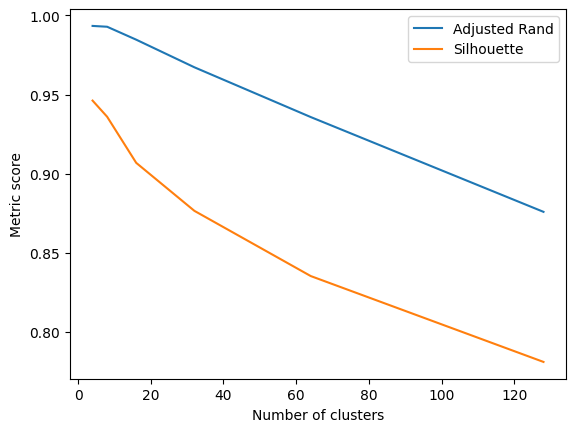

In [9]:
cc_ar_scores = list()
cc_sil_scores = list()
cc_average_times = list()
for cc in cluster_counts:
    sum_adjusted_rand = 0
    sum_sil = 0
    total_time = 0
    for blob in cc_blob_dict[cc]:
        start_time = time()
        hdb = HDBSCAN()
        pred = hdb.fit_predict(z_scale_np_array(blob[0]))
        sum_adjusted_rand += adjusted_rand_score(blob[1], pred)
        sum_sil += silhouette_score(blob[0], pred)
        total_time += time() - start_time
    average_adjusted_rand = sum_adjusted_rand / n
    average_sil = sum_sil / n
    average_time = total_time / n

    cc_ar_scores.append(average_adjusted_rand)
    cc_sil_scores.append(average_sil)
    cc_average_times.append(average_time)

cc_overall_average_ar = sum(cc_ar_scores)/len(sample_sizes)
print(cc_overall_average_ar)

cc_overall_average_sil = sum(cc_sil_scores)/len(sample_sizes)
print(cc_overall_average_sil)

plt.xlabel("Number of clusters")
plt.ylabel("Metric score")

plt.plot(cluster_counts, cc_ar_scores, label="Adjusted Rand")
plt.plot(cluster_counts, cc_sil_scores, label="Silhouette")

plt.legend()
plt.show()
# Adjusted rand score and silhouette score decrease as the number
# of cluster increases
# Possible explanations are that HDBSCAN performance worsens as
# number of clusters increase or
# the way we generate the data might be the reason for this degradation

In [10]:
hdbscan_average_ar = (cc_overall_average_ar + ss_overall_average_ar)/2
hdbscan_average_sil = (cc_overall_average_sil + ss_overall_average_sil)/2
hdbscan_average_ar, hdbscan_average_sil

(0.8718923345116341, 0.7969512176644239)

# Experiment 2: Determining algorithm complexity with respect to number of samples and number of clusters

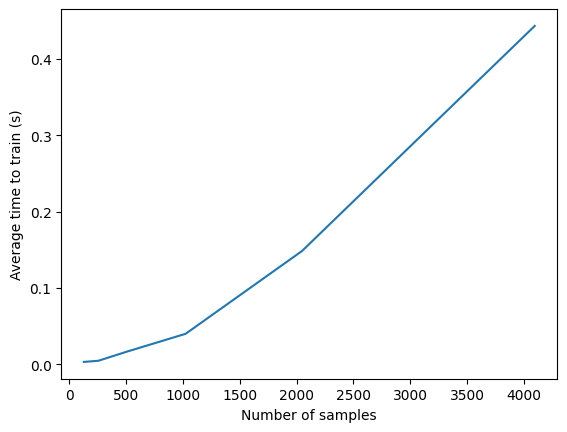

In [11]:
plt.xlabel("Number of samples")
plt.ylabel("Average time to train (s)")
plt.plot(sample_sizes, ss_average_times)
# Possibly O(n^2) complexity

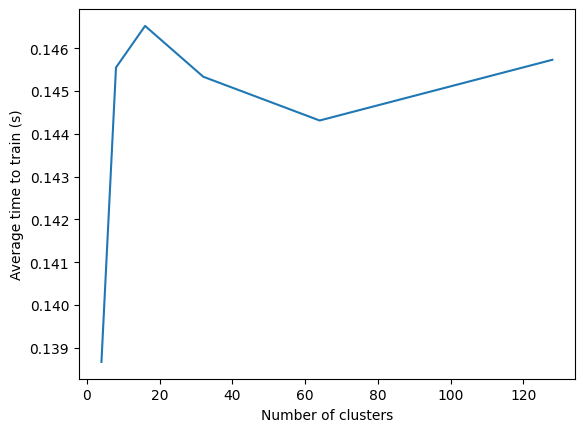

In [12]:
plt.xlabel("Number of clusters")
plt.ylabel("Average time to train (s)")
plt.plot(cluster_counts, cc_average_times)
# Complexity is not apparent, plateau at around 20 clusters

# Experiment 3A: Real world problems

The datasets that we will be using shows a combination of all/some of these traits
- Non-linearly separable
- Noise points
- Varying cluster density
- Overlapping of clusters

## Worms
It's a plot with an exterme amount of noise points. I'm guessing it would be difficult for the clustering algorithms to determine the clusters. It has 1 million rows, so training might take a while.

In [19]:
worms_df = pd.read_csv("./data/worms/worms_2d.txt", sep=" ", header=None)
worms_df

,0,1
0,4260.1,3476.0
1,4276.3,3475.6
2,4260.2,3475.3
3,4244.4,3494.8
4,4270.0,3467.1
...,...,...
105595,3567.9,3583.4
105596,3383.9,3897.8
105597,3259.6,2970.7
105598,2688.7,2958.6


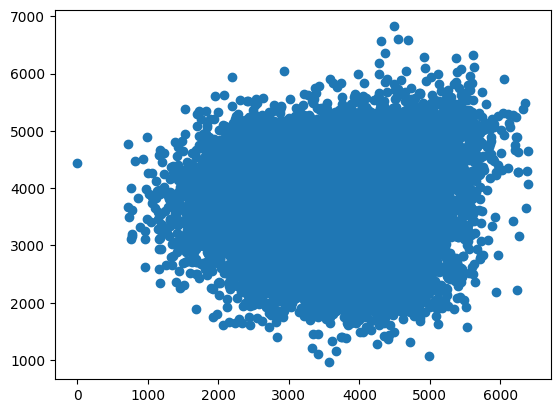

In [20]:
worms_arr = worms_df.to_numpy()
worms_arr_scaled = z_scale_np_array(worms_arr)
xs, ys = zip(*worms_arr)
plt.scatter(xs, ys)
# I can barely make out any clusters

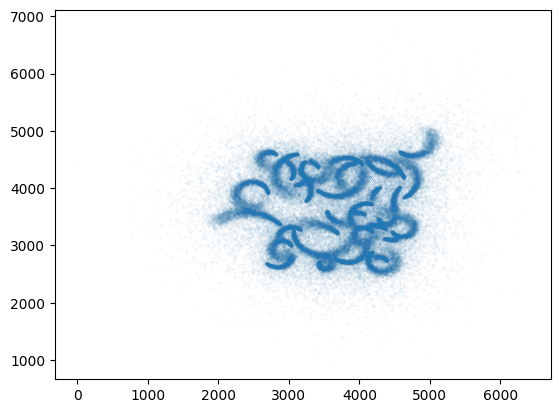

In [21]:
# Reduce the size of the points
plt.scatter(xs, ys, s=0.001)

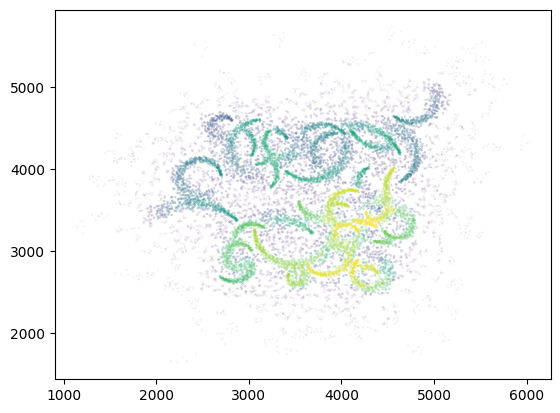

In [22]:
hdb = HDBSCAN()
worms_predictions = hdb.fit_predict(worms_arr_scaled)
plot_without_noise(xs, ys, worms_predictions, s=0.001)

In [23]:
len(set(worms_predictions)), sum(1 if i == -1 else 0 for i in worms_predictions)
# It has 4928 clusters and 48573 points labeled as "noise"

(4928, 48573)

## As expected, the performance is poor because there are alot of noise points.

# T48K

Non linearly separable data set with some noise points

In [2]:
t48k_df = pd.read_csv("./data/t48k.txt", sep=" ")
t48k_df

,8000,2
0,68.601997,102.491997
1,454.665985,264.808990
2,101.283997,169.285995
3,372.614990,263.140991
4,300.989014,46.555000
...,...,...
7995,442.420990,303.721985
7996,495.451996,288.502991
7997,267.605011,141.725006
7998,238.358002,252.729996


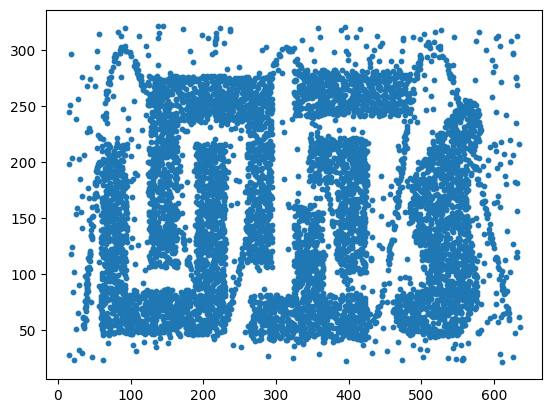

In [3]:
t48k_arr = t48k_df.to_numpy()
t48k_arr_scaled = z_scale_np_array(t48k_arr)
xs, ys = zip(*t48k_arr)
plt.scatter(xs, ys, s=10)

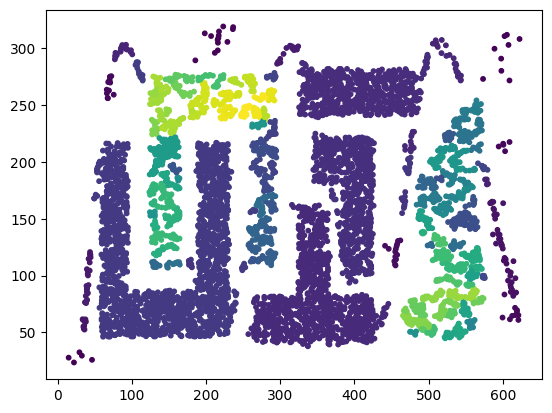

In [4]:
hdb = HDBSCAN()
t48k_predictions = hdb.fit_predict(t48k_arr_scaled)
plot_without_noise(xs, ys, t48k_predictions, s=10)

In [47]:
len(set(t48k_predictions)), sum(1 if i == -1 else 0 for i in t48k_predictions)
# It has 192 clusters and 1678 points labeled as "noise"

(192, 1678)

## Maybe needs hyperparameter tuning.

# Jain

Differing cluster density

In [5]:
jain_df = pd.read_csv("./data/jain.txt", sep="\t", header=None)
jain_df

,0,1,2
0,0.85,17.45,2
1,0.75,15.60,2
2,3.30,15.45,2
3,5.25,14.20,2
4,4.90,15.65,2
...,...,...,...
368,38.75,16.85,1
369,39.00,16.60,1
370,38.25,17.35,1
371,39.50,16.95,1


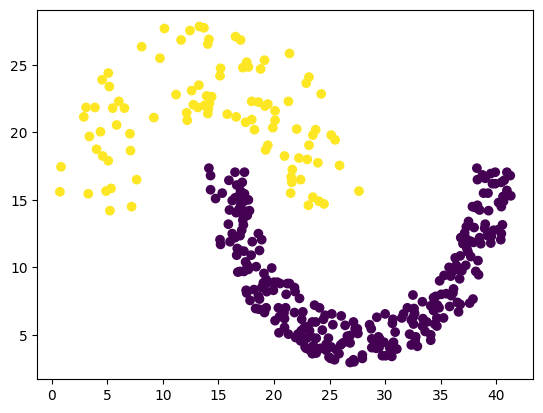

In [6]:
jain_arr = jain_df.to_numpy()
jain_arr_scaled = z_scale_np_array(jain_arr)
xs, ys, cs = zip(*jain_arr)
plt.scatter(xs, ys, c=cs)

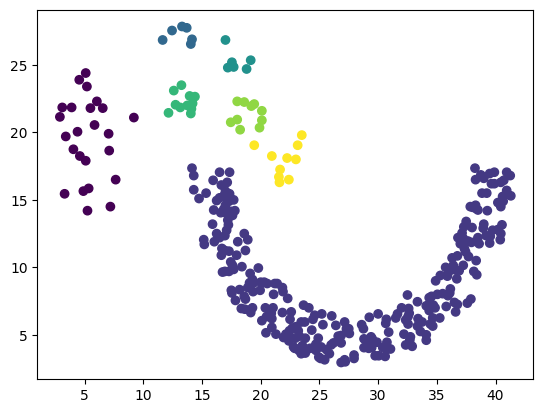

In [7]:
jain_input = jain_df.drop(jain_df.columns[2], axis=1)
hdb = HDBSCAN()
jain_predictions = hdb.fit_predict(jain_input)
plot_without_noise(xs, ys, jain_predictions)

In [8]:
len(set(jain_predictions)), sum(1 if i == -1 else 0 for i in jain_predictions)
# It has 8 clusters and 30 points labeled as "noise"

(8, 30)

## The main point of HDBSCAN was that it is DBSCAN that can classify clusters with varying density. It doesn't seem to do that here. Maybe need hyperparameter tuning again.

# Path-based

Non-linearly separable and several clusters are inside one cluster

In [9]:
pathbased_df = pd.read_csv("./data/pathbased.txt", sep="\t", header=None)
pathbased_df

,0,1,2
0,11.25,5.05,1
1,10.95,4.70,1
2,9.85,5.80,1
3,9.80,5.75,1
4,9.15,6.80,1
...,...,...,...
295,17.50,18.05,2
296,16.65,17.50,2
297,15.45,17.30,2
298,15.45,17.80,2


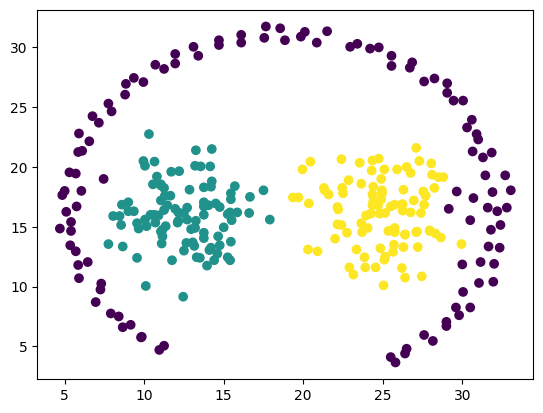

In [10]:
pathbased_arr = pathbased_df.to_numpy()
pathbased_arr_scaled = z_scale_np_array(pathbased_arr)
xs, ys, cs = zip(*pathbased_arr)
plt.scatter(xs, ys, c=cs)

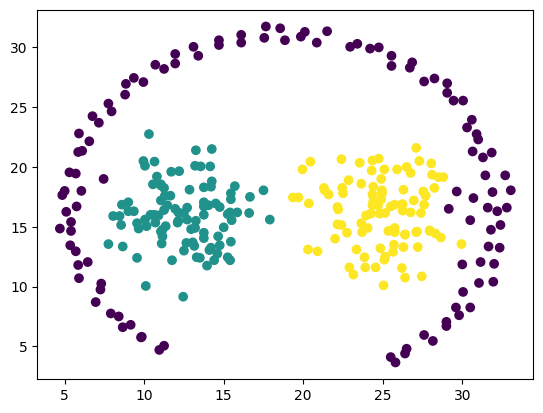

In [11]:
pathbased_input = pathbased_df.drop(pathbased_df.columns[2], axis=1)
hdb = HDBSCAN()
pathbased_predictions = hdb.fit_predict(pathbased_arr_scaled)
plot_without_noise(xs, ys, pathbased_predictions)

In [55]:
len(set(pathbased_predictions)), sum(1 if i == -1 else 0 for i in pathbased_predictions)
# It has 3 clusters and 0 points labeled as "noise"
## Note that the performance is better with scaling.
## (The current one is scaling.)

(3, 0)

# Unbalance

In [14]:
unbalance_df = pd.read_csv("./data/unbalance2.txt", sep=" ", header=None)
unbalance_df

,0,1
0,151700,351102
1,155799,354358
2,142857,352716
3,152726,349144
4,151008,349692
...,...,...
6495,218990,412773
6496,213767,393738
6497,226754,394768
6498,221605,396515


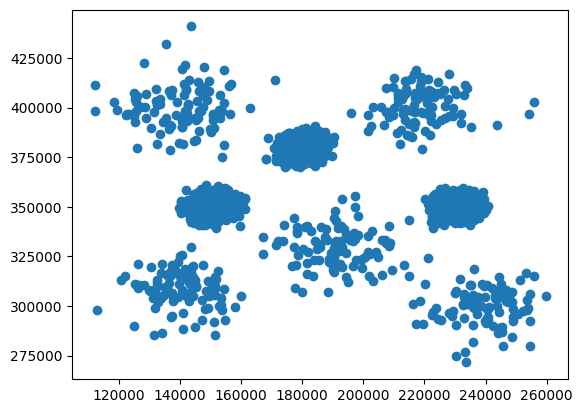

In [15]:
unbalance_arr = unbalance_df.to_numpy()
unbalance_arr_scaled = z_scale_np_array(unbalance_arr)
xs, ys = zip(*unbalance_arr)
plt.scatter(xs, ys)

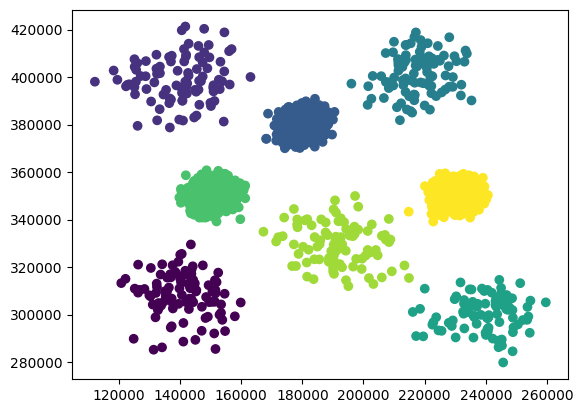

In [17]:
hdb = HDBSCAN()
unbalance_predictions = hdb.fit_predict(unbalance_arr_scaled)
plot_without_noise(xs, ys, unbalance_predictions)

In [18]:
len(set(unbalance_predictions)), sum(1 if i == -1 else 0 for i in unbalance_predictions)
# It has 9 clusters and 26 points labeled as "noise"

(9, 26)

## Works well with different density